<a href="https://colab.research.google.com/github/Mainakdeb/deceptive-digits/blob/main/deceptive-digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 2
batch_size = 64
image_size = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
lr = 2e-4
beta1 = 0.5
ngpu = 1

transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.RandomRotation(25),
     transforms.ToTensor(),
     transforms.Normalize(
         [0.5 for _ in range(nc)], 
         [0.5 for _ in range(nc)]
         )
    ]
)

dataset = datasets.MNIST(root="/dataset/", train=True, transform=transforms, download=True)

dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True, drop_last=True)

In [72]:
device

device(type='cuda')

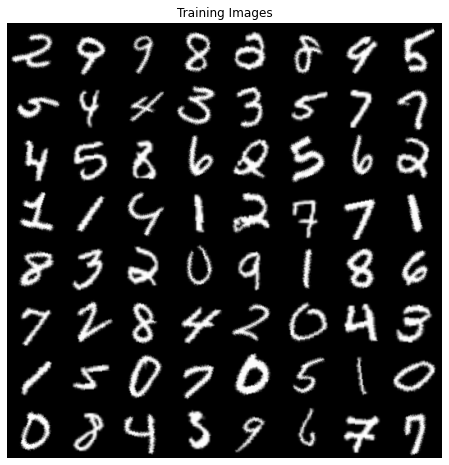

In [73]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [123]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        #meta data (label)    
        self.label_emb = nn.Embedding(10, 10)

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(nz+10, ngf*8,
            kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(ngf*8, ngf*4,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(ngf*4, ngf*2,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(ngf*2, ngf,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        
        # # Input Dimension: (ngf*2) x 16 x 16
        # self.tconv5 = nn.ConvTranspose2d(ngf, ngf,
        #     4, 2, 1, bias=False)
        # self.bn5 = nn.BatchNorm2d(ngf)

        # Input Dimension: (ngf) * 32 * 32
        self.tconv6 = nn.ConvTranspose2d(ngf, nc,
            4, 2, 1, bias=False)
        #Output Dimension: (nc) x 64 x 64

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.unsqueeze(2).unsqueeze(3)

        #print(c.size())
        #print(x.size())
        x = torch.cat([x, c], 1)
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        #x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv6(x))

        return x

netG = Generator(ngpu).to(device)
print(netG)

Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [124]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        #meta data (label)
        self.label_emb = nn.Embedding(10, 10)

        # Input Dimension: (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf,
            4, 2, 1, bias=False)

        # # Input Dimension: (nc) x 64 x 64
        # self.conv2 = nn.Conv2d(ndf, ndf,
        #     4, 2, 1, bias=False)
        # self.bn2 = nn.BatchNorm2d(ndf*1)

        # Input Dimension: (ndf) x 32 x 32
        self.conv3 = nn.Conv2d(ndf, ndf*2,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*2)

        # Input Dimension: (ndf*2) x 16 x 16
        self.conv4 = nn.Conv2d(ndf*2, ndf*4,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*4)

        # Input Dimension: (ndf*4) x 8 x 8
        self.conv5 = nn.Conv2d(ndf*4, ndf*8,
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        # Input Dimension: (ndf*8) x 4 x 4
        self.conv6 = nn.Conv2d(ndf*8, 10, 4, 1, 0, bias=False)

        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 1)

    def forward(self, x, labels):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        #print(x.size())
        #x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        #print(x.size())
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.leaky_relu(self.conv6(x))
        x = torch.flatten(x, 1)

        c = self.label_emb(labels)
        #print(x.size())
        #print(c.size())
        x = torch.cat([x, c], 1)
        #print(x.size())
        #print(c.size())
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        #print(x.size())

        return x

netD = Discriminator(ngpu).to(device)
print(netD)

Discriminator(
  (label_emb): Embedding(10, 10)
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=20, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=1, bias=True)
)


In [125]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [126]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

In [127]:
num_epochs = 6

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #print((data[1]))
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        real_labels = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, real_labels).view(-1)
        # Calculate loss on all-real batch
        # print(output[0])
        # print(label[0])
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
        # Generate fake image batch with G
        fake = netG(noise, fake_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # print training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fake_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/6][0/937]	Loss_D: 1.3971	Loss_G: 0.8272	D(x): 0.4695	D(G(z)): 0.4724 / 0.4382


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/6][50/937]	Loss_D: 0.0842	Loss_G: 4.3825	D(x): 0.9752	D(G(z)): 0.0569 / 0.0129
[0/6][100/937]	Loss_D: 0.2943	Loss_G: 4.7062	D(x): 0.9756	D(G(z)): 0.2324 / 0.0096
[0/6][150/937]	Loss_D: 0.3116	Loss_G: 3.8952	D(x): 0.9245	D(G(z)): 0.1988 / 0.0226
[0/6][200/937]	Loss_D: 0.7395	Loss_G: 3.4416	D(x): 0.8753	D(G(z)): 0.4216 / 0.0349
[0/6][250/937]	Loss_D: 0.2182	Loss_G: 2.9372	D(x): 0.9438	D(G(z)): 0.1449 / 0.0570
[0/6][300/937]	Loss_D: 0.4128	Loss_G: 2.7404	D(x): 0.8790	D(G(z)): 0.2350 / 0.0693
[0/6][350/937]	Loss_D: 2.2313	Loss_G: 3.4149	D(x): 0.1429	D(G(z)): 0.0099 / 0.0363
[0/6][400/937]	Loss_D: 4.1659	Loss_G: 0.0647	D(x): 0.9923	D(G(z)): 0.9831 / 0.9380
[0/6][450/937]	Loss_D: 0.6280	Loss_G: 3.0119	D(x): 0.8818	D(G(z)): 0.3645 / 0.0545
[0/6][500/937]	Loss_D: 0.9133	Loss_G: 1.4494	D(x): 0.6444	D(G(z)): 0.3306 / 0.2701
[0/6][550/937]	Loss_D: 0.8559	Loss_G: 1.5046	D(x): 0.6863	D(G(z)): 0.3354 / 0.2476
[0/6][600/937]	Loss_D: 0.6936	Loss_G: 3.5186	D(x): 0.9078	D(G(z)): 0.4189 / 0.0313
[0/6]

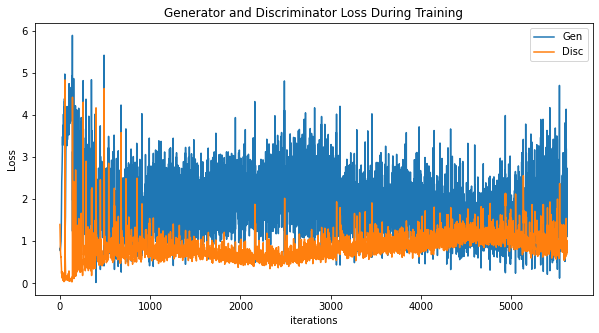

In [128]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Gen")
plt.plot(D_losses,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


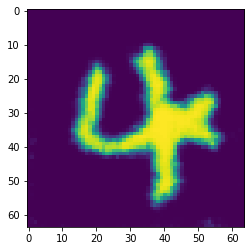

In [131]:
def generate_digit_from_label(label):
  single_noise = torch.randn(1, nz, 1, 1, device=device)
  fake_label = torch.tensor([label]).cuda()
#   print("sn", single_noise.shape)
#   print("label", fake_label.shape)
  with torch.no_grad():
    fake_ = netG(single_noise, fake_label).detach().cpu()
#   print(single_noise.shape, fake_label.shape)
#   print(type(single_noise), type(fake_label))
  return(fake_.squeeze())

plt.imshow(generate_digit_from_label(4))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


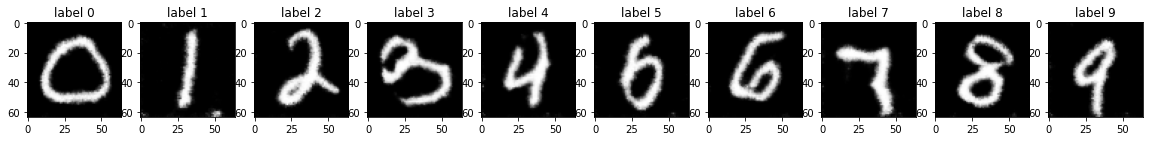

In [135]:
fig, axes = plt.subplots(1,10, figsize = (20,8))

axes[0].set_title('label 0')
axes[0].imshow(generate_digit_from_label(0), cmap="gray")
axes[1].set_title('label 1')
axes[1].imshow(generate_digit_from_label(1), cmap="gray")
axes[2].set_title('label 2')
axes[2].imshow(generate_digit_from_label(2), cmap="gray")
axes[3].set_title('label 3')
axes[3].imshow(generate_digit_from_label(3), cmap="gray")
axes[4].set_title('label 4')
axes[4].imshow(generate_digit_from_label(4), cmap="gray")
axes[5].set_title('label 5')
axes[5].imshow(generate_digit_from_label(5), cmap="gray")
axes[6].set_title('label 6')
axes[6].imshow(generate_digit_from_label(6), cmap="gray")
axes[7].set_title('label 7')
axes[7].imshow(generate_digit_from_label(7), cmap="gray")
axes[8].set_title('label 8')
axes[8].imshow(generate_digit_from_label(8), cmap="gray")
axes[9].set_title('label 9')
axes[9].imshow(generate_digit_from_label(9), cmap="gray")

In [140]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
n=20
pts = generate_latent_points(100, n)
interps = []
for i in range(0, n, 2):
    interpolated = interpolate_points(pts[i], pts[i+1], n_steps = 10)    
    z = torch.tensor(interpolated).float().cuda()
    z=z.unsqueeze(2).unsqueeze(3)
    #print(z.shape)
    labels_ = torch.LongTensor(np.ones(10, dtype=int)*i//2).cuda()
    #print(labels_.shape)
    images = netG(z,labels_).detach().cpu().numpy()
    # for x in images:
    #     plt.imshow(x[0])
    #     plt.show()
    interps.append(images)
interps=np.array(interps)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


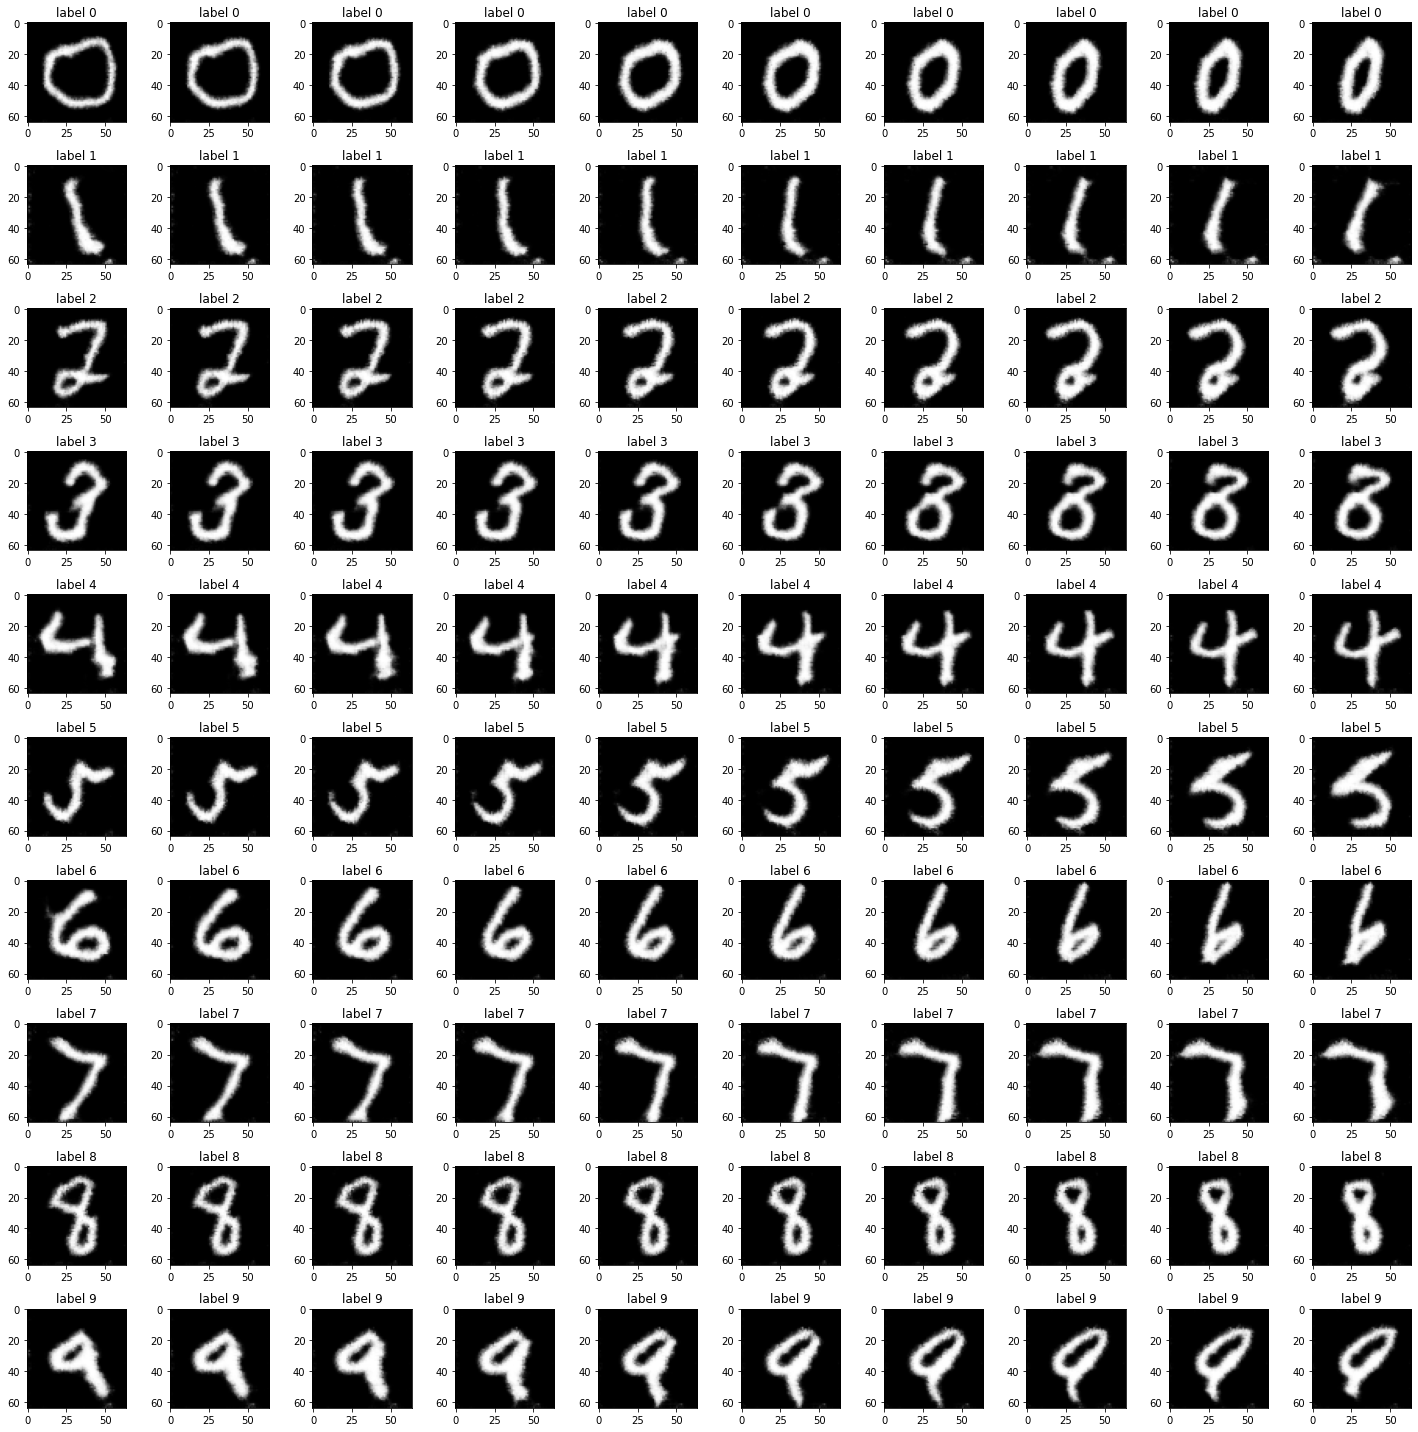

In [141]:
#Big Plot
fig, axes = plt.subplots(10,10, figsize = (20,20))
for i in range(0, 10):
    for j in range(0,10):
        axes[i,j].set_title('label '+str(i))
        axes[i,j].imshow(interps[i][j][0], cmap='gray')

plt.tight_layout()
plt.show()